# Traffic Aggregation

In [1]:
import sys
sys.path.insert(1, '../../../../utils')
import numpy as np
from numpy import log, ndarray, array, mean, sqrt, arange
from pandas import read_csv, DataFrame, Series, to_timedelta, date_range, to_datetime
from matplotlib.pyplot import figure, savefig, show, subplots, plot, legend, setp
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
import dslabs_functions
from dslabs_functions import plot_line_chart, HEIGHT, ts_aggregation_by, set_chart_labels, plot_components, plot_multiline_chart, \
series_train_test_split, plot_forecasting_series, plot_multibar_chart, FORECAST_MEASURES, plot_forecasting_eval, plot_forecasting_series, \
PersistenceOptimistRegressor, PersistenceRealistRegressor
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap
from statsmodels.tsa.stattools import adfuller
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression

In [2]:
target = 'Total'
timecol="Time"
filename = "../../data/raw/TrafficTwoMonth.csv"
file_tag = "traffic"
data: DataFrame = read_csv(filename, na_values="", parse_dates=[timecol])

data.index = date_range(start='2000-01-01', periods=len(data), freq='15min', name="Time")
series: Series = data[target]
data.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
Time,,,,,,,,,
2000-01-01 00:00:00,2025-12-12 00:00:00,10,Tuesday,13,2,2,24,41,normal
2000-01-01 00:15:00,2025-12-12 00:15:00,10,Tuesday,14,1,1,36,52,normal
2000-01-01 00:30:00,2025-12-12 00:30:00,10,Tuesday,10,2,2,32,46,normal
2000-01-01 00:45:00,2025-12-12 00:45:00,10,Tuesday,10,2,2,36,50,normal
2000-01-01 01:00:00,2025-12-12 01:00:00,10,Tuesday,11,2,1,34,48,normal


**Train/Test Split**

In [3]:
# splits temporally, since we sorted by date above
train, test = series_train_test_split(series, 0.80)
train.head()
test.head()

Time
2000-02-19 14:15:00    109
2000-02-19 14:30:00    106
2000-02-19 14:45:00    128
2000-02-19 15:00:00    111
2000-02-19 15:15:00    147
Freq: 15min, Name: Total, dtype: int64

**MVI Analysis** - there are no missing values in the train or test set, verified below:

In [4]:
train.isna().sum(), test.isna().sum()

(np.int64(0), np.int64(0))

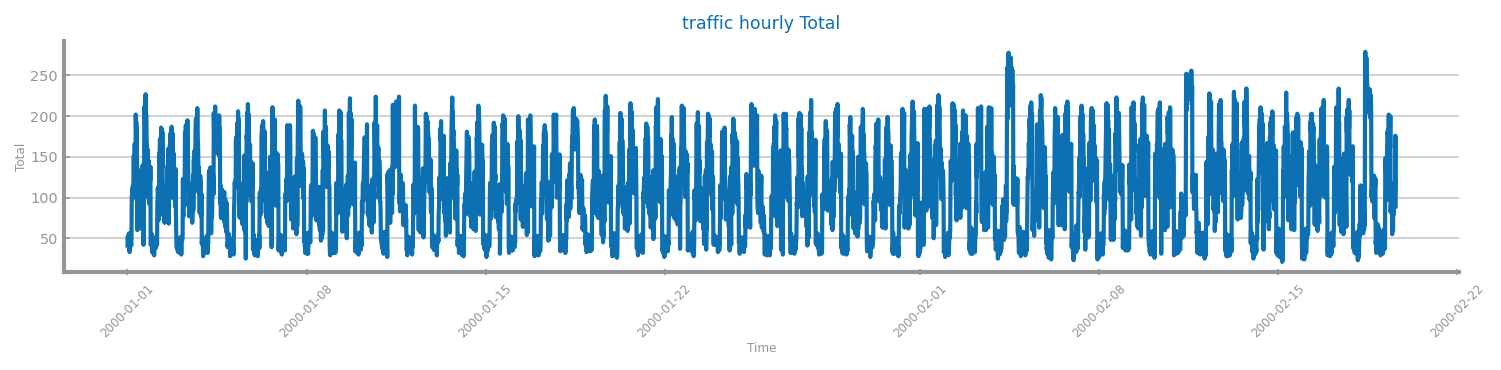

In [22]:
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    train.index.to_list(),
    train.to_list(),
    xlabel=train.index.name,
    ylabel=target,
    title=f"{file_tag} hourly {target}",
)
show()

**Aggregation**

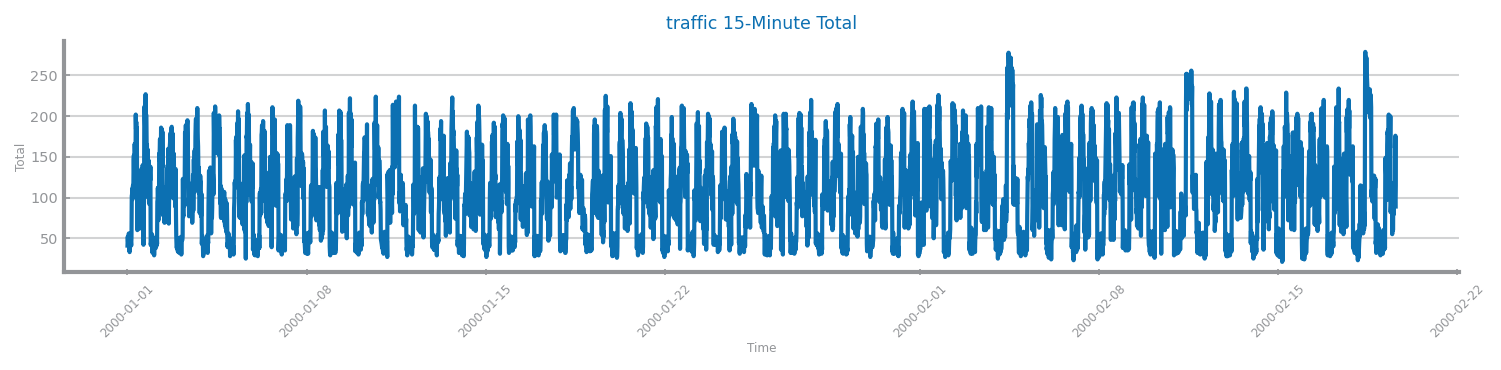

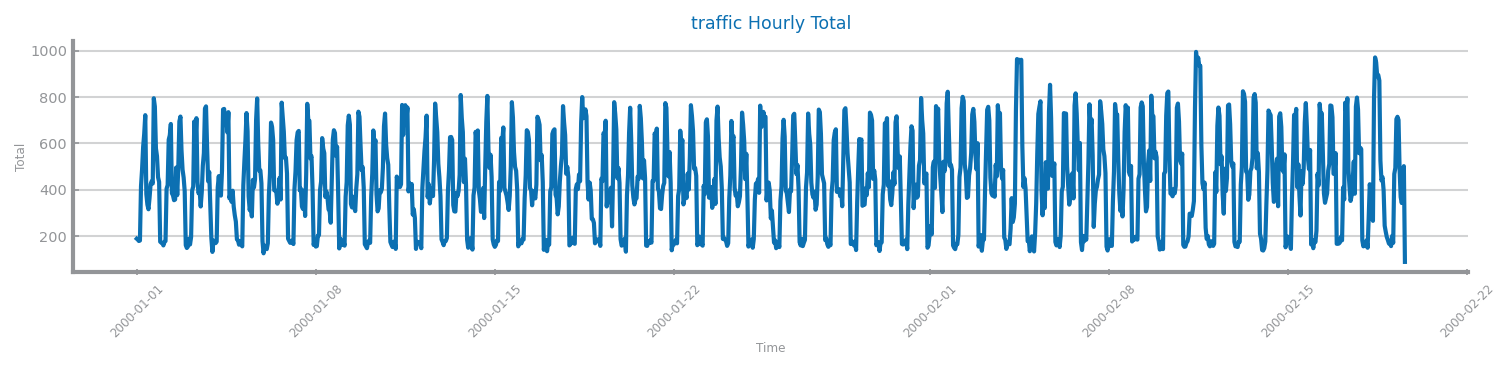

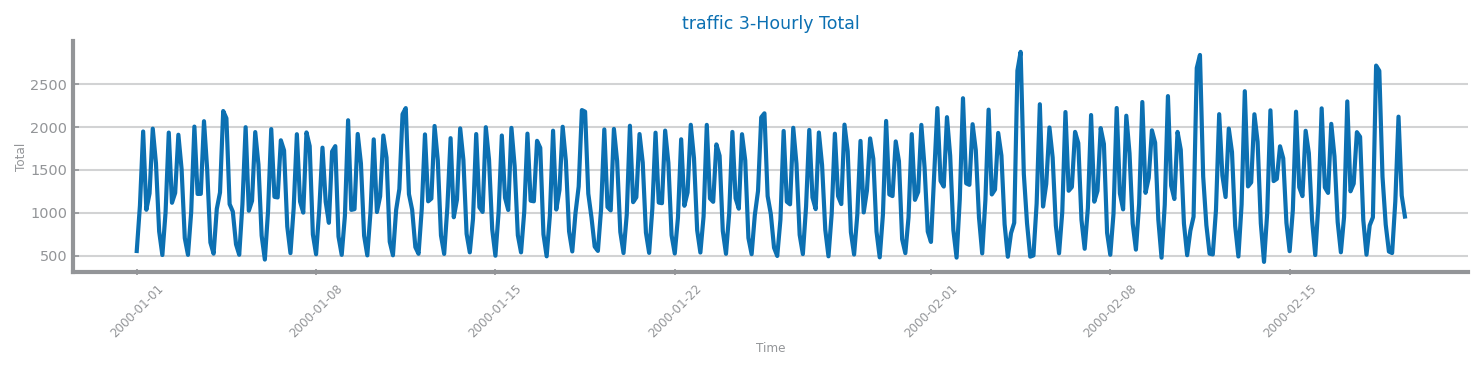

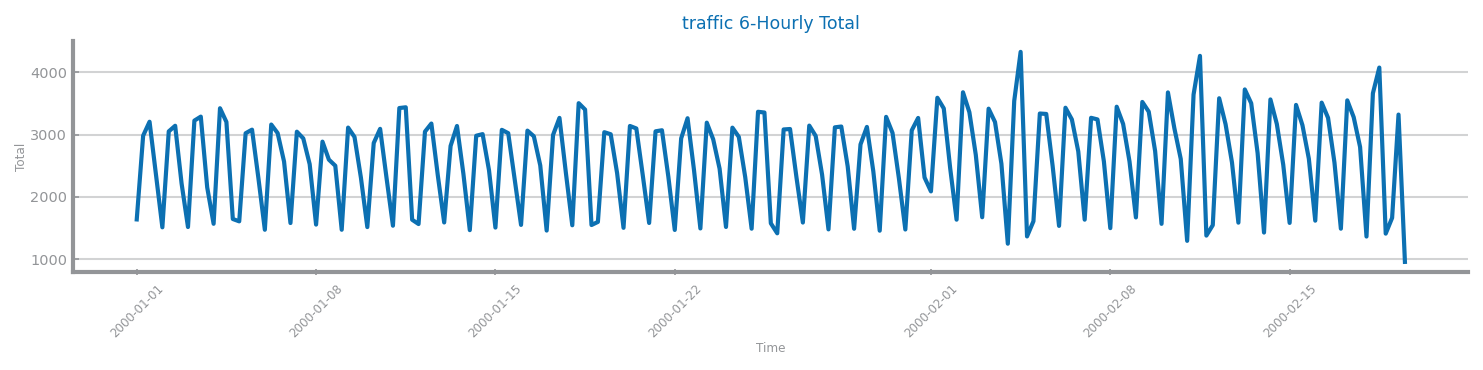

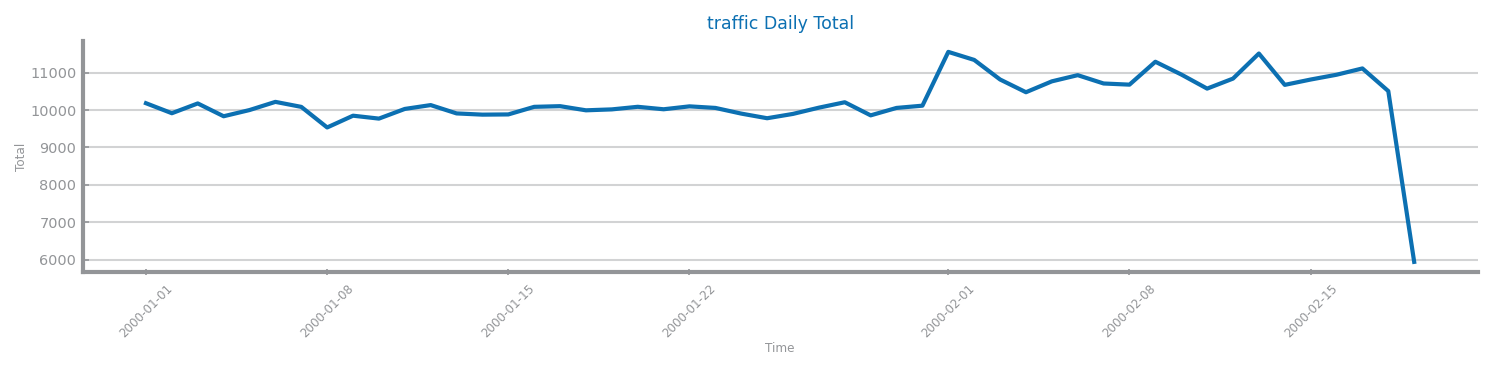

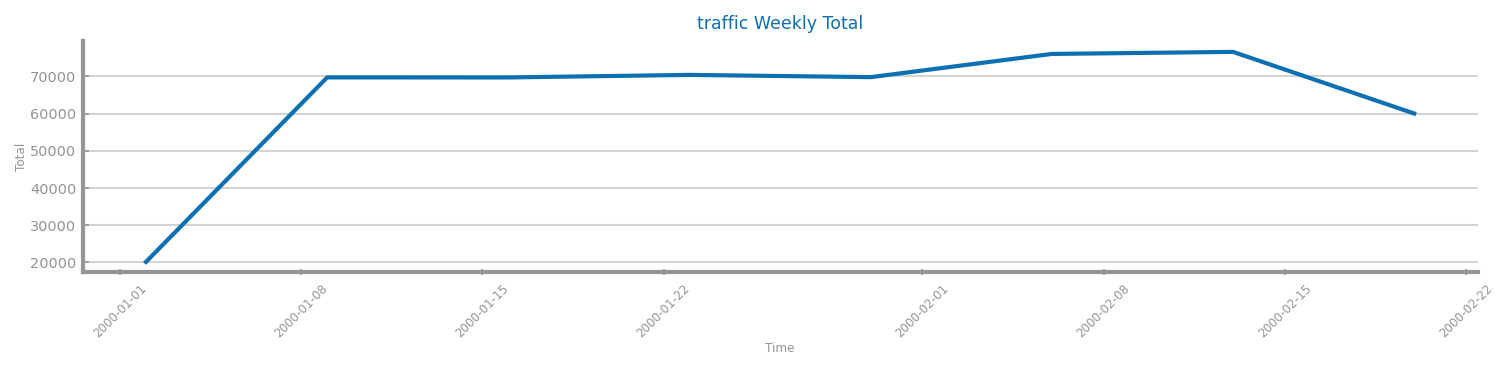

In [5]:
# trying aggregates of hourly, 3-hourly, 6-hourly, daily, and weekly

series_H_train: Series = ts_aggregation_by(train, gran_level="H", agg_func=sum)
series_H_test: Series = ts_aggregation_by(test, gran_level="H", agg_func=sum)

series_3H_train: Series = ts_aggregation_by(train, gran_level="3h", agg_func=sum)
series_3H_test: Series = ts_aggregation_by(test, gran_level="3h", agg_func=sum)

series_6H_train: Series = ts_aggregation_by(train, gran_level="6h", agg_func=sum)
series_6H_test: Series = ts_aggregation_by(test, gran_level="6h", agg_func=sum)

series_D_train: Series = ts_aggregation_by(train, gran_level="D", agg_func=sum)
series_D_test: Series = ts_aggregation_by(test, gran_level="D", agg_func=sum)

series_W_train: Series = ts_aggregation_by(train, gran_level="W", agg_func=sum)
series_W_test: Series = ts_aggregation_by(test, gran_level="W", agg_func=sum)

# plotting the training sets for each

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    train.index.to_list(),
    train.to_list(),
    xlabel=train.index.name,
    ylabel=target,
    title=f"{file_tag} 15-Minute {target}",
)
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series_H_train.index.to_list(),
    series_H_train.to_list(),
    xlabel=series_H_train.index.name,
    ylabel=target,
    title=f"{file_tag} Hourly {target}",
)
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series_3H_train.index.to_list(),
    series_3H_train.to_list(),
    xlabel=series_3H_train.index.name,
    ylabel=target,
    title=f"{file_tag} 3-Hourly {target}",
)
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series_6H_train.index.to_list(),
    series_6H_train.to_list(),
    xlabel=series_6H_train.index.name,
    ylabel=target,
    title=f"{file_tag} 6-Hourly {target}",
)
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series_D_train.index.to_list(),
    series_D_train.to_list(),
    xlabel=series_D_train.index.name,
    ylabel=target,
    title=f"{file_tag} Daily {target}",
)
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series_W_train.index.to_list(),
    series_W_train.to_list(),
    xlabel=series_W_train.index.name,
    ylabel=target,
    title=f"{file_tag} Weekly {target}",
)
show()


**Evaluation**

**Persistent Realist**

In [6]:
# Initialize metrics storage
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

metrics_results = {}

def store_metrics(model_name, aggregation, train_series, test_series, prd_trn, prd_tst):
    """Store metrics for a given model and aggregation level"""
    key = f"{model_name}_{aggregation}"
    metrics_results[key] = {
        "model": model_name,
        "aggregation": aggregation,
        "train_rmse": sqrt(mean_squared_error(train_series, prd_trn)),
        "test_rmse": sqrt(mean_squared_error(test_series, prd_tst)),
        "train_mae": mean_absolute_error(train_series, prd_trn),
        "test_mae": mean_absolute_error(test_series, prd_tst),
        "train_mape": mean_absolute_percentage_error(train_series, prd_trn),
        "test_mape": mean_absolute_percentage_error(test_series, prd_tst),
        "train_r2": r2_score(train_series, prd_trn),
        "test_r2": r2_score(test_series, prd_tst),
    }
    return metrics_results[key]


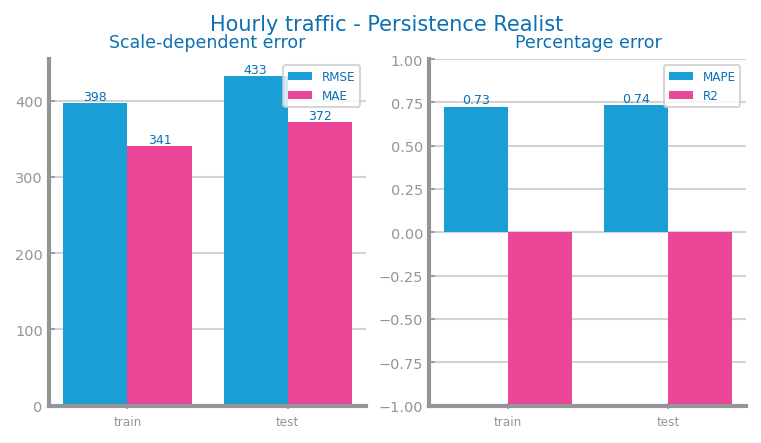

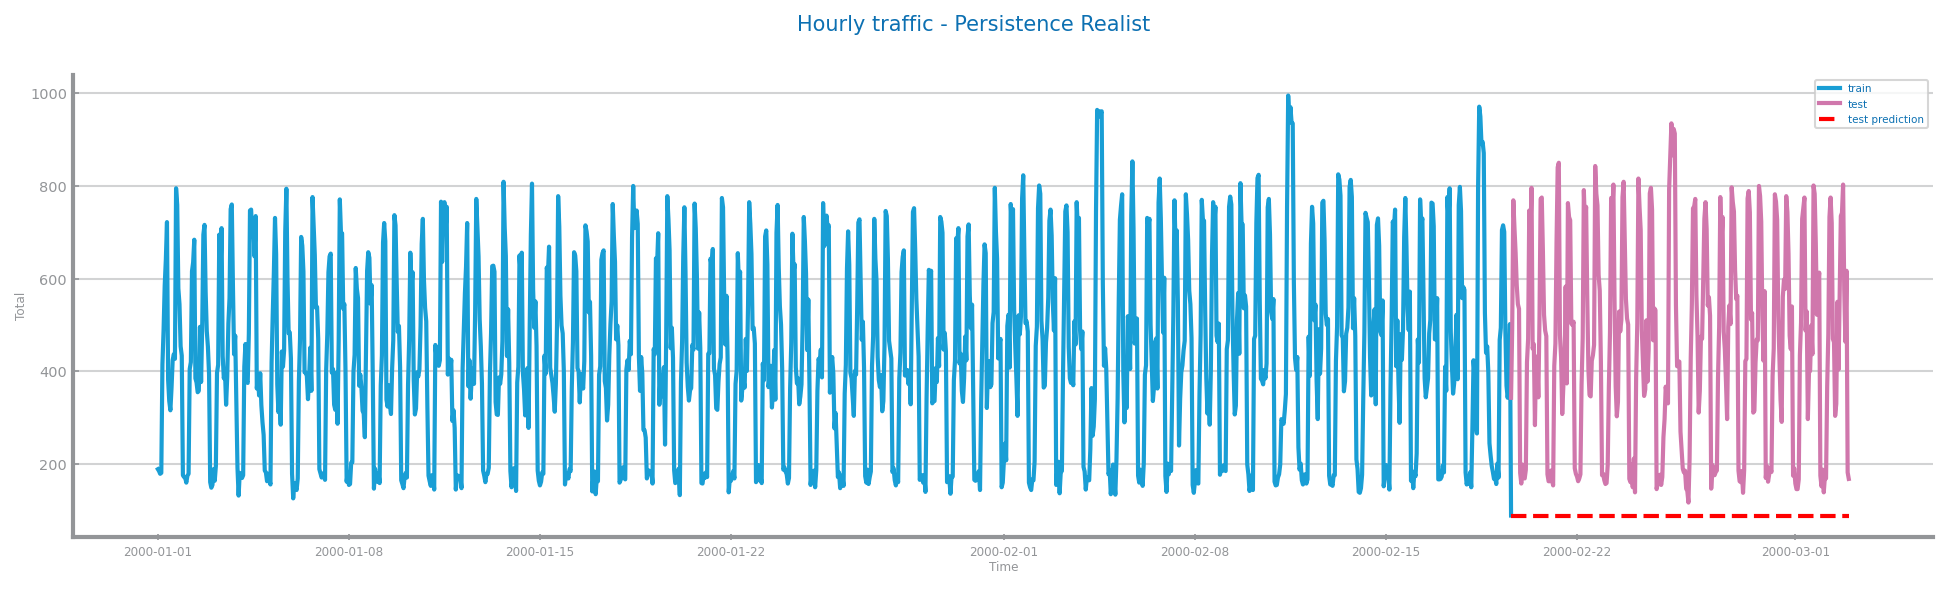

In [7]:
fr_mod = PersistenceRealistRegressor()
fr_mod.fit(series_H_train)
prd_trn_H: Series = fr_mod.predict(series_H_train)
prd_tst_H: Series = fr_mod.predict(series_H_test)

store_metrics("Persistence_Realist", "H", series_H_train, series_H_test, prd_trn_H, prd_tst_H)

plot_forecasting_eval(series_H_train, series_H_test, prd_trn_H, prd_tst_H, title=f"Hourly {file_tag} - Persistence Realist")
savefig(f"../../charts/preparation/aggregation/{file_tag}_persistence_real_H_eval.png")

plot_forecasting_series(
    series_H_train,
    series_H_test,
    prd_tst_H,
    title=f"Hourly {file_tag} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/aggregation/{file_tag}_persistence_real_H_forecast.png")


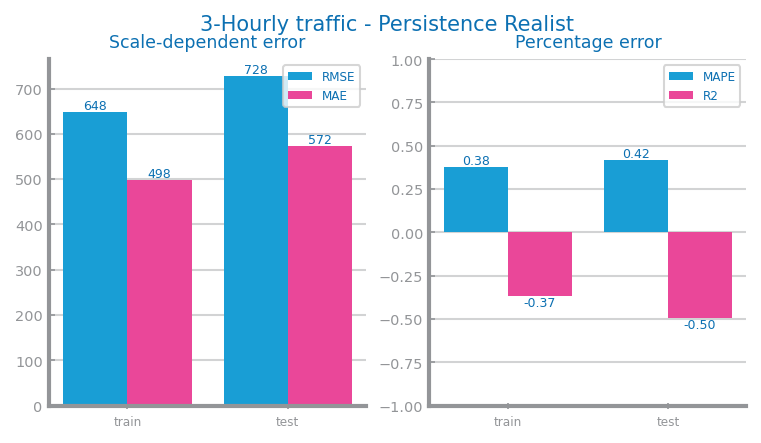

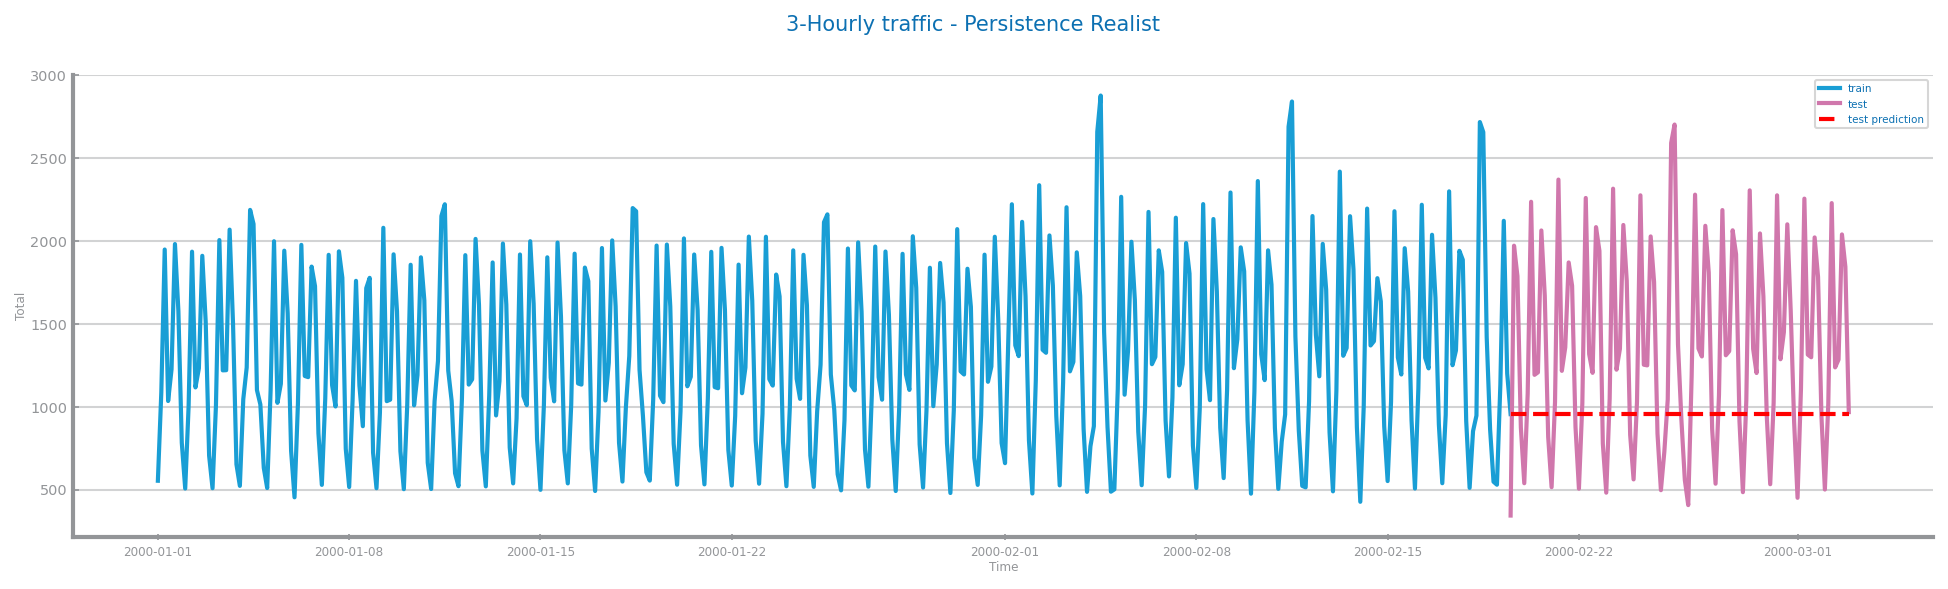

In [8]:
fr_mod = PersistenceRealistRegressor()
fr_mod.fit(series_3H_train)
prd_trn_3H: Series = fr_mod.predict(series_3H_train)
prd_tst_3H: Series = fr_mod.predict(series_3H_test)

store_metrics("Persistence_Realist", "3H", series_3H_train, series_3H_test, prd_trn_3H, prd_tst_3H)

plot_forecasting_eval(series_3H_train, series_3H_test, prd_trn_3H, prd_tst_3H, title=f"3-Hourly {file_tag} - Persistence Realist")
savefig(f"../../charts/preparation/aggregation/{file_tag}_persistence_real_3H_eval.png")

plot_forecasting_series(
    series_3H_train,
    series_3H_test,
    prd_tst_3H,
    title=f"3-Hourly {file_tag} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/aggregation/{file_tag}_persistence_real_3H_forecast.png")


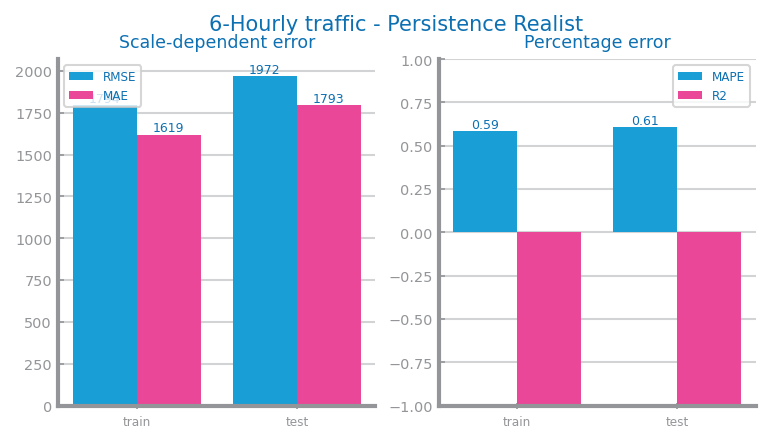

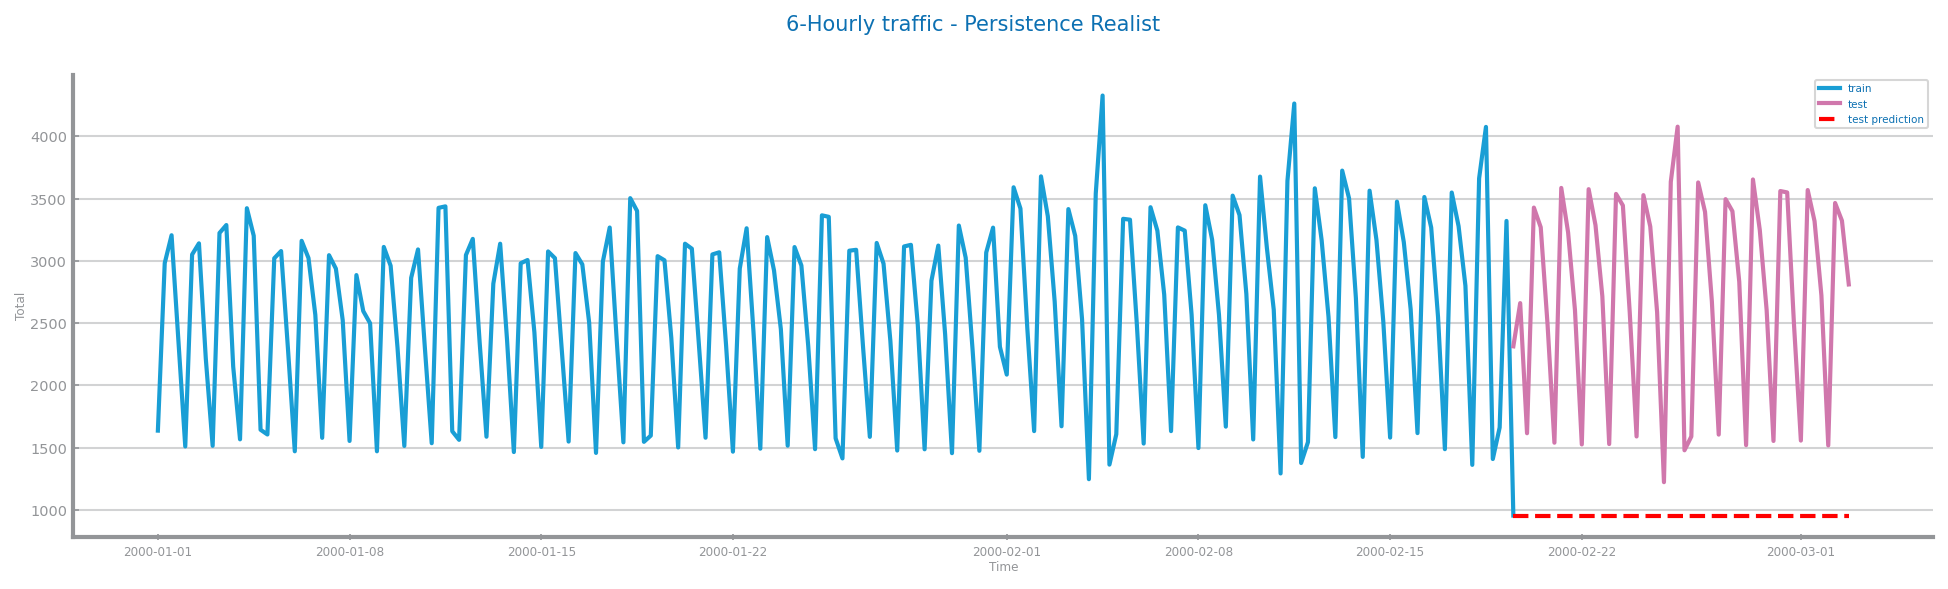

In [9]:
fr_mod = PersistenceRealistRegressor()
fr_mod.fit(series_6H_train)
prd_trn_6H: Series = fr_mod.predict(series_6H_train)
prd_tst_6H: Series = fr_mod.predict(series_6H_test)

store_metrics("Persistence_Realist", "6H", series_6H_train, series_6H_test, prd_trn_6H, prd_tst_6H)

plot_forecasting_eval(series_6H_train, series_6H_test, prd_trn_6H, prd_tst_6H, title=f"6-Hourly {file_tag} - Persistence Realist")
savefig(f"../../charts/preparation/aggregation/{file_tag}_persistence_real_6H_eval.png")

plot_forecasting_series(
    series_6H_train,
    series_6H_test,
    prd_tst_6H,
    title=f"6-Hourly {file_tag} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/aggregation/{file_tag}_persistence_real_6H_forecast.png")


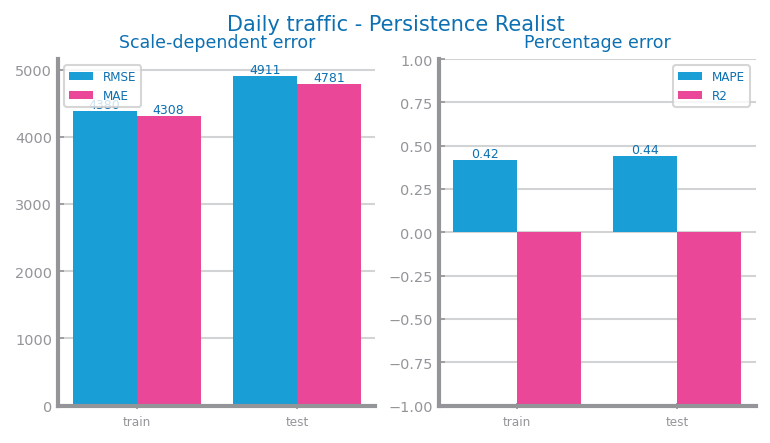

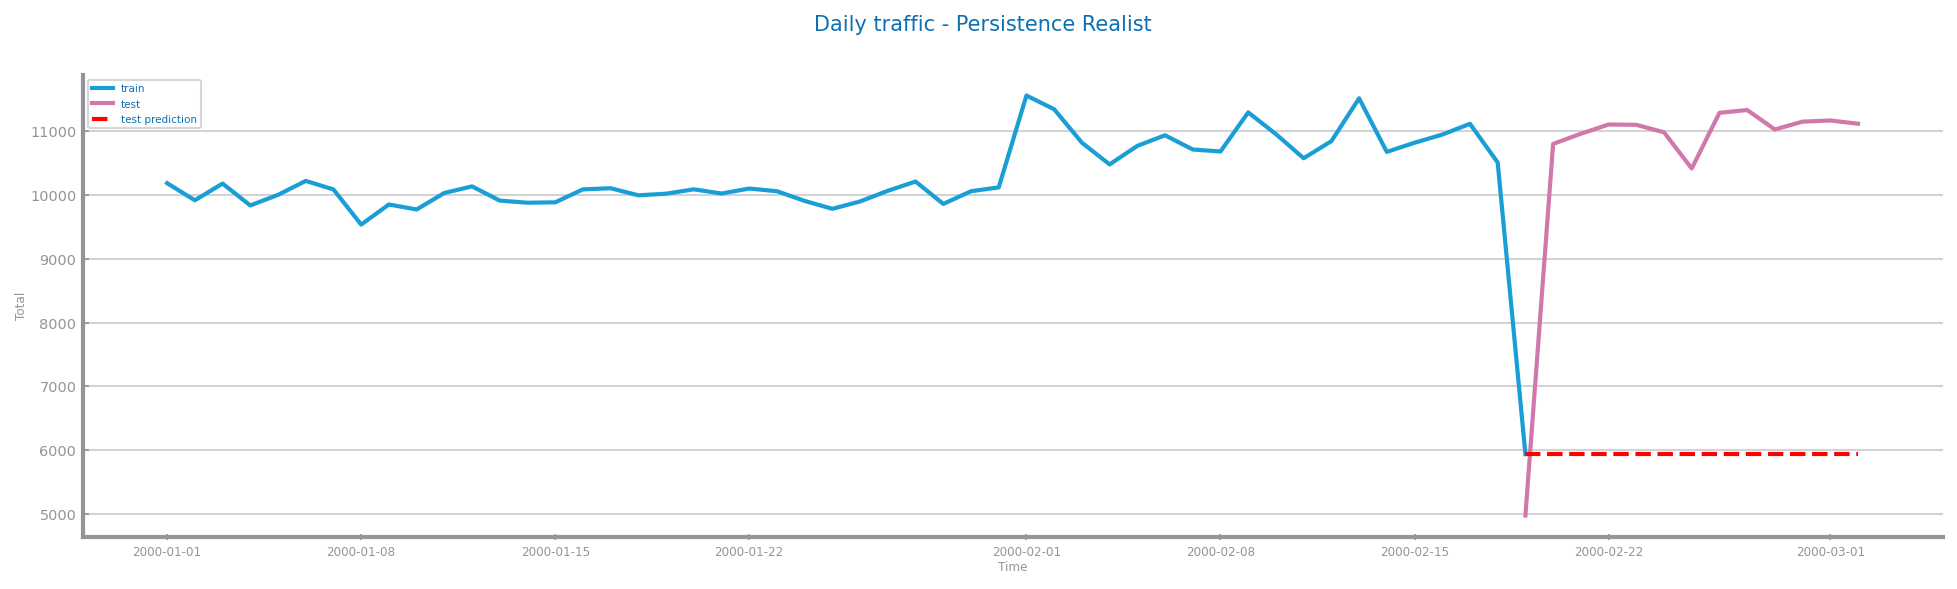

In [10]:
fr_mod = PersistenceRealistRegressor()
fr_mod.fit(series_D_train)
prd_trn_D: Series = fr_mod.predict(series_D_train)
prd_tst_D: Series = fr_mod.predict(series_D_test)

store_metrics("Persistence_Realist", "D", series_D_train, series_D_test, prd_trn_D, prd_tst_D)

plot_forecasting_eval(series_D_train, series_D_test, prd_trn_D, prd_tst_D, title=f"Daily {file_tag} - Persistence Realist")
savefig(f"../../charts/preparation/aggregation/{file_tag}_persistence_real_D_eval.png")

plot_forecasting_series(
    series_D_train,
    series_D_test,
    prd_tst_D,
    title=f"Daily {file_tag} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/aggregation/{file_tag}_persistence_real_D_forecast.png")


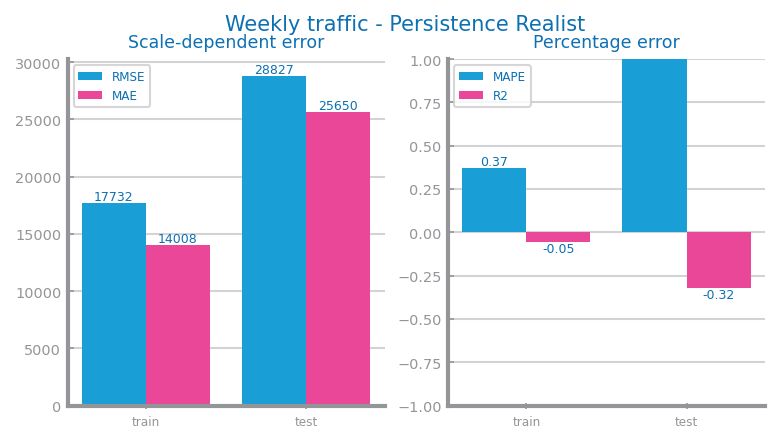

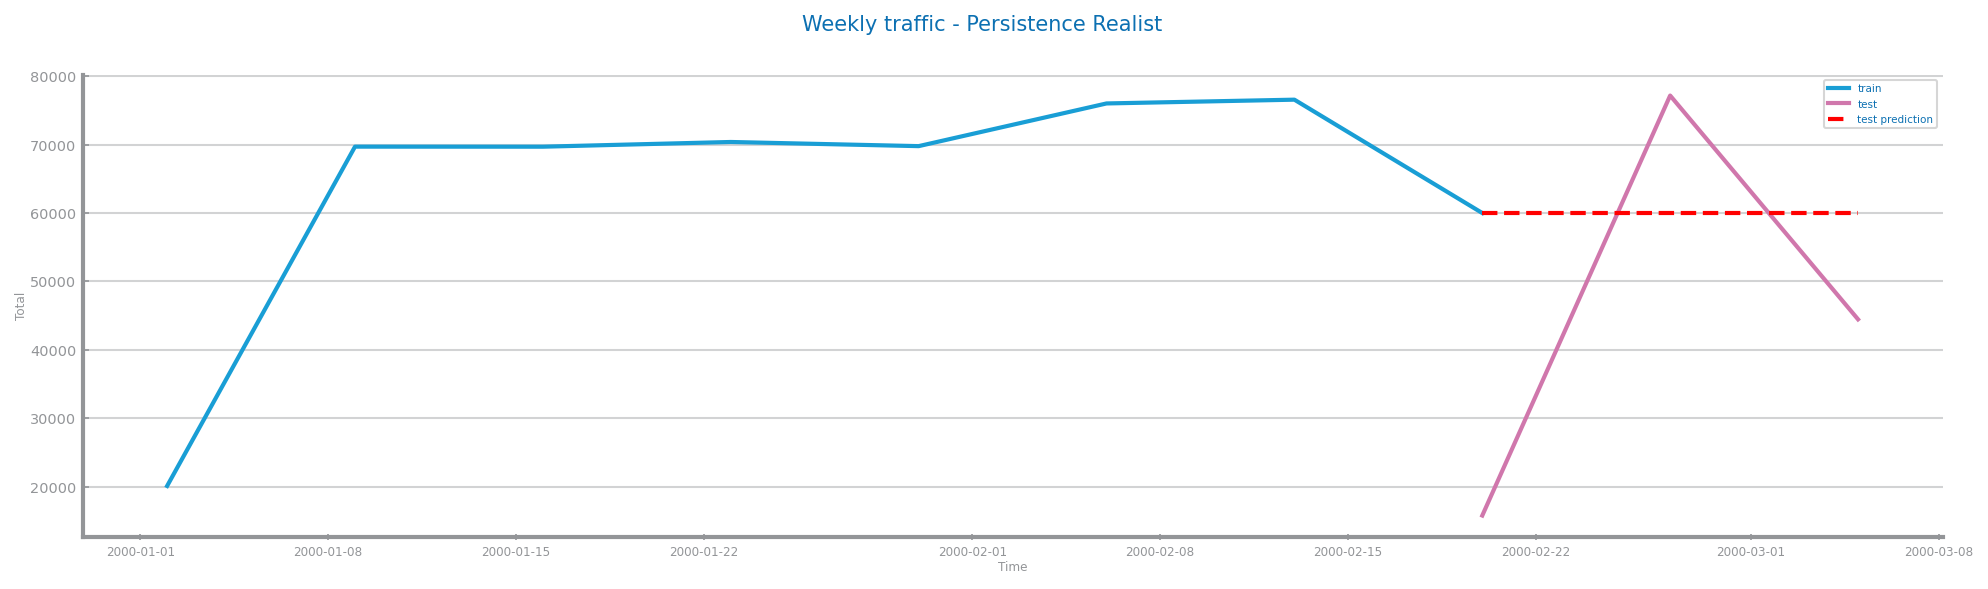

In [11]:
fr_mod = PersistenceRealistRegressor()
fr_mod.fit(series_W_train)
prd_trn_W: Series = fr_mod.predict(series_W_train)
prd_tst_W: Series = fr_mod.predict(series_W_test)

store_metrics("Persistence_Realist", "W", series_W_train, series_W_test, prd_trn_W, prd_tst_W)

plot_forecasting_eval(series_W_train, series_W_test, prd_trn_W, prd_tst_W, title=f"Weekly {file_tag} - Persistence Realist")
savefig(f"../../charts/preparation/aggregation/{file_tag}_persistence_real_W_eval.png")

plot_forecasting_series(
    series_W_train,
    series_W_test,
    prd_tst_W,
    title=f"Weekly {file_tag} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/aggregation/{file_tag}_persistence_real_W_forecast.png")


**Linear Regression**

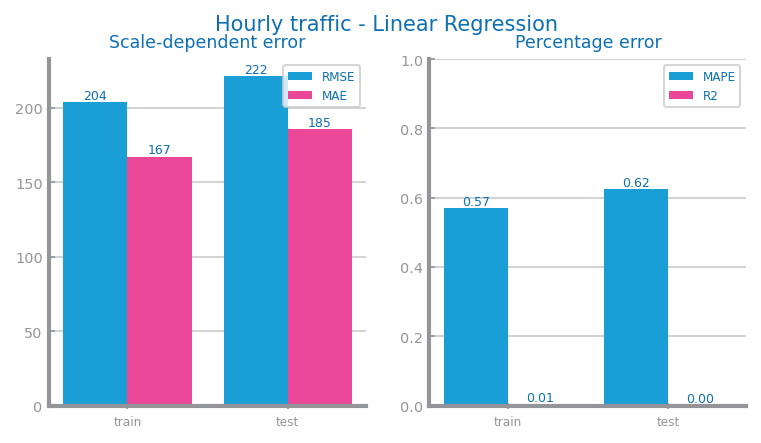

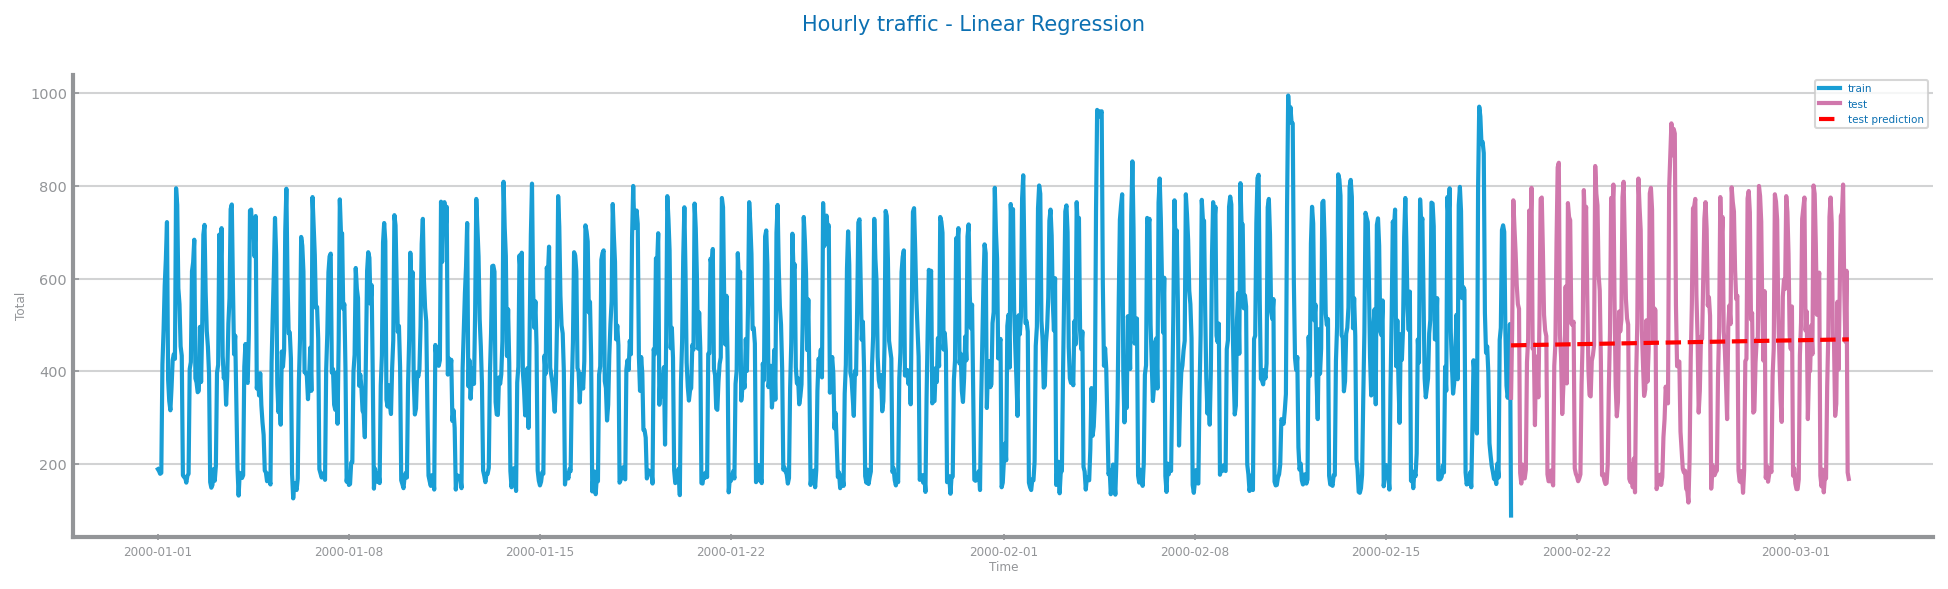

In [12]:
n_trn = len(series_H_train)
n_tst = len(series_H_test)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = series_H_train.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = series_H_test.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn_H: Series = Series(model.predict(trnX), index=series_H_train.index)
prd_tst_H: Series = Series(model.predict(tstX), index=series_H_test.index)

plot_forecasting_eval(
    series_H_train,
    series_H_test,
    prd_trn_H,
    prd_tst_H,
    title=f"Hourly {file_tag} - Linear Regression"
)
savefig(f"../../charts/preparation/aggregation/{file_tag}_linear_regression_H_eval.png")

plot_forecasting_series(
    series_H_train,
    series_H_test,
    prd_tst_H,
    title=f"Hourly {file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/aggregation/{file_tag}_linear_regression_H_forecast.png")

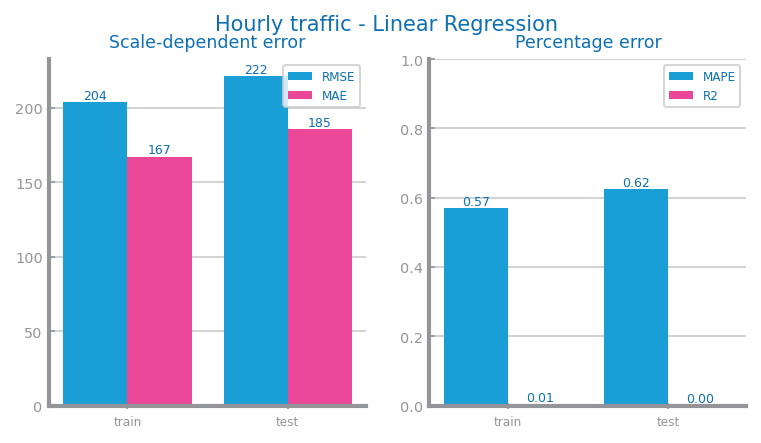

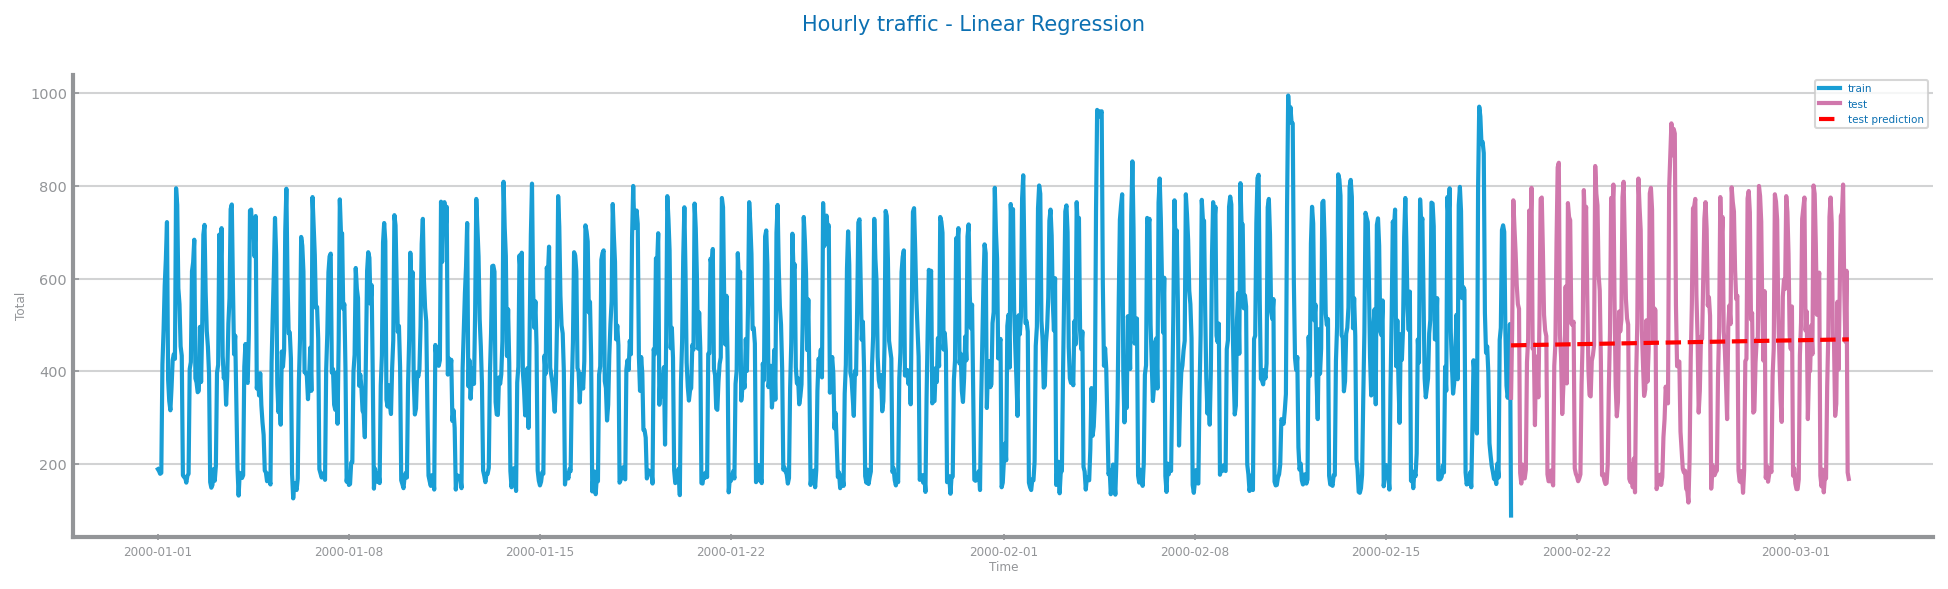

In [13]:
n_trn = len(series_H_train)
n_tst = len(series_H_test)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = series_H_train.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = series_H_test.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn_H: Series = Series(model.predict(trnX), index=series_H_train.index)
prd_tst_H: Series = Series(model.predict(tstX), index=series_H_test.index)

store_metrics("Linear_Regression", "H", series_H_train, series_H_test, prd_trn_H, prd_tst_H)

plot_forecasting_eval(
    series_H_train,
    series_H_test,
    prd_trn_H,
    prd_tst_H,
    title=f"Hourly {file_tag} - Linear Regression"
)
savefig(f"../../charts/preparation/aggregation/{file_tag}_linear_regression_H_eval.png")

plot_forecasting_series(
    series_H_train,
    series_H_test,
    prd_tst_H,
    title=f"Hourly {file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/aggregation/{file_tag}_linear_regression_H_forecast.png")


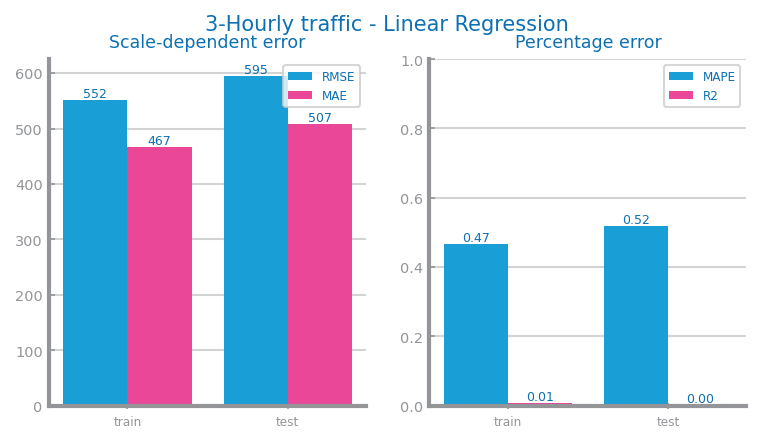

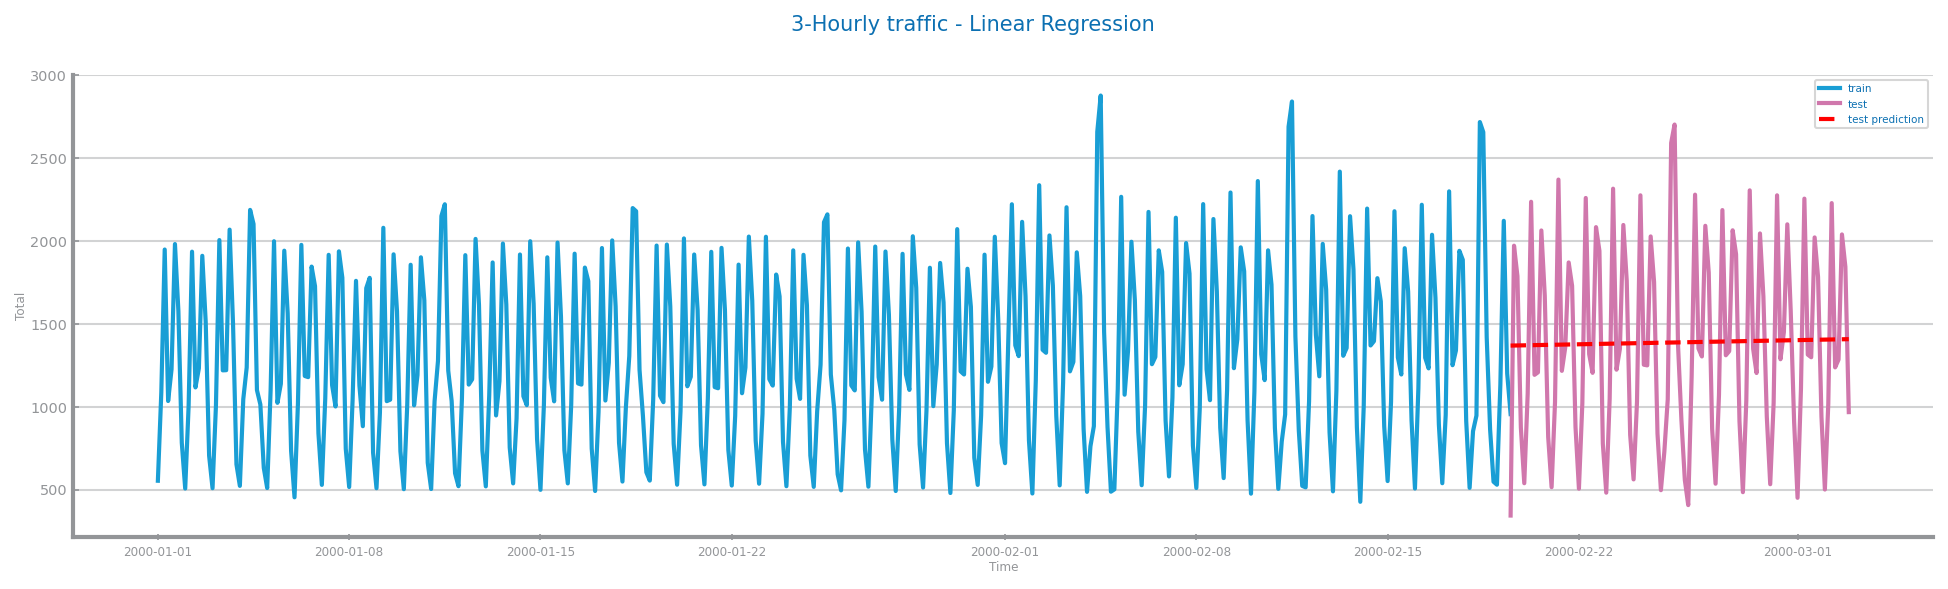

In [14]:
n_trn = len(series_3H_train)
n_tst = len(series_3H_test)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = series_3H_train.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = series_3H_test.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn_3H: Series = Series(model.predict(trnX), index=series_3H_train.index)
prd_tst_3H: Series = Series(model.predict(tstX), index=series_3H_test.index)

store_metrics("Linear_Regression", "3H", series_3H_train, series_3H_test, prd_trn_3H, prd_tst_3H)

plot_forecasting_eval(
    series_3H_train,
    series_3H_test,
    prd_trn_3H,
    prd_tst_3H,
    title=f"3-Hourly {file_tag} - Linear Regression"
)
savefig(f"../../charts/preparation/aggregation/{file_tag}_linear_regression_3H_eval.png")

plot_forecasting_series(
    series_3H_train,
    series_3H_test,
    prd_tst_3H,
    title=f"3-Hourly {file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/aggregation/{file_tag}_linear_regression_3H_forecast.png")


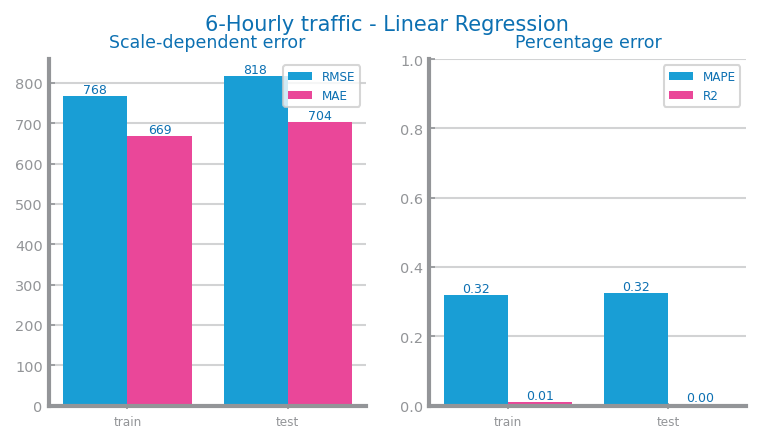

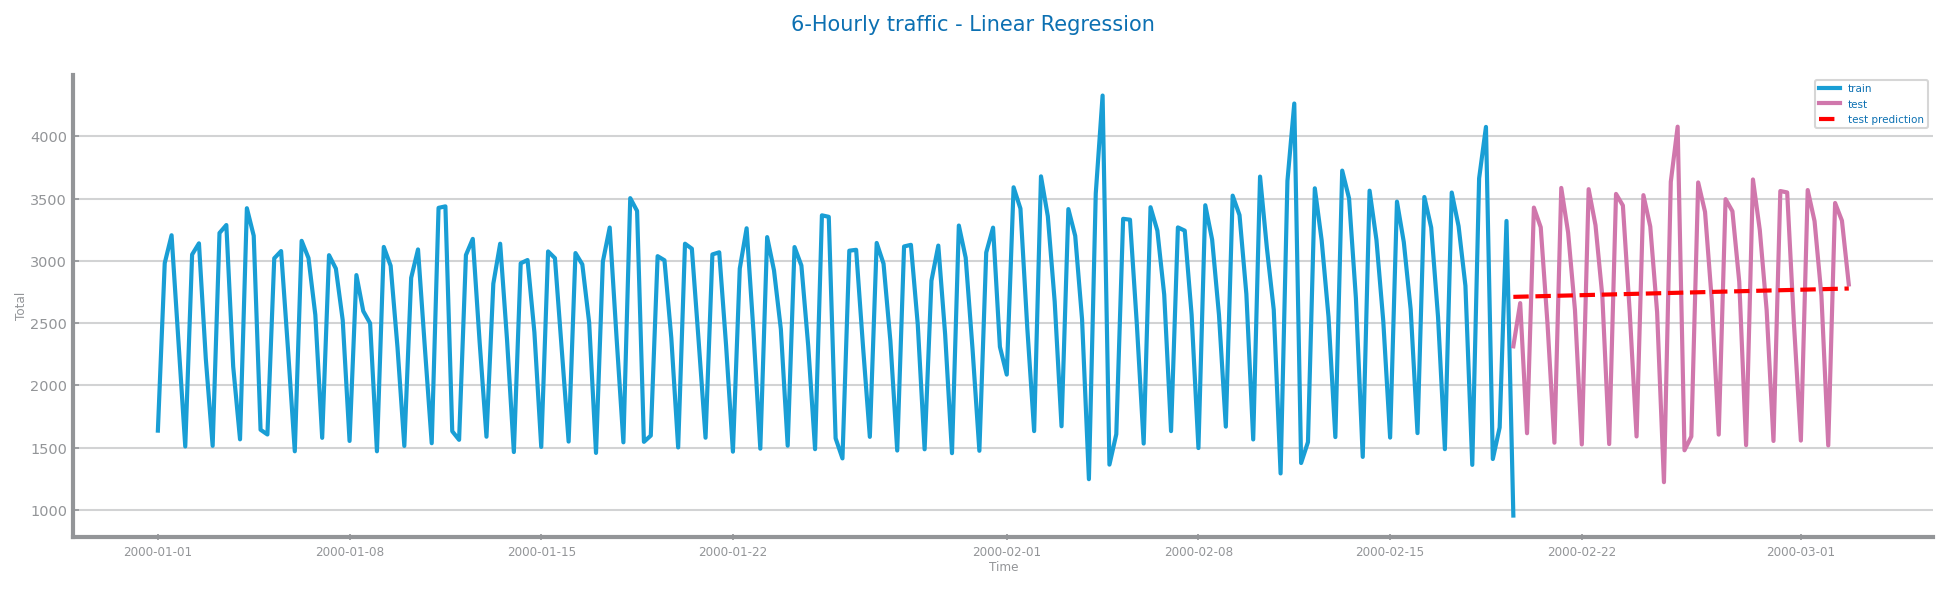

In [15]:
n_trn = len(series_6H_train)
n_tst = len(series_6H_test)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = series_6H_train.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = series_6H_test.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn_6H: Series = Series(model.predict(trnX), index=series_6H_train.index)
prd_tst_6H: Series = Series(model.predict(tstX), index=series_6H_test.index)

store_metrics("Linear_Regression", "6H", series_6H_train, series_6H_test, prd_trn_6H, prd_tst_6H)

plot_forecasting_eval(
    series_6H_train,
    series_6H_test,
    prd_trn_6H,
    prd_tst_6H,
    title=f"6-Hourly {file_tag} - Linear Regression"
)
savefig(f"../../charts/preparation/aggregation/{file_tag}_linear_regression_6H_eval.png")

plot_forecasting_series(
    series_6H_train,
    series_6H_test,
    prd_tst_6H,
    title=f"6-Hourly {file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/aggregation/{file_tag}_linear_regression_6H_forecast.png")


In [ ]:
# Convert metrics to DataFrame for easy comparison
metrics_df = DataFrame.from_dict(metrics_results, orient='index')
metrics_df = metrics_df.reset_index(drop=True)

# Display all metrics
print("="*80)
print("ALL MODEL METRICS (Test Set)")
print("="*80)
display_df = metrics_df[['model', 'aggregation', 'test_rmse', 'test_mae', 'test_mape', 'test_r2']].copy()
display_df = display_df.sort_values(['model', 'aggregation'])
print(display_df.to_string(index=False))
print()

# Find best models by different criteria
print("="*80)
print("BEST MODELS BY CRITERIA (Test Set)")
print("="*80)

# Best by MAPE (scale-independent, good for comparing across aggregations)
best_mape = metrics_df.loc[metrics_df['test_mape'].idxmin()]
print(f"Best MAPE: {best_mape['model']} ({best_mape['aggregation']}) = {best_mape['test_mape']:.4f}")

# Best by R2 (scale-independent)
best_r2 = metrics_df.loc[metrics_df['test_r2'].idxmax()]
print(f"Best R²: {best_r2['model']} ({best_r2['aggregation']}) = {best_r2['test_r2']:.4f}")

# Best by MAE for each aggregation level
print(f"\nBest MAE by Aggregation Level:")
for agg in ['H', '3H', '6H', 'D', 'W']:
    agg_df = metrics_df[metrics_df['aggregation'] == agg]
    best_mae_agg = agg_df.loc[agg_df['test_mae'].idxmin()]
    print(f"  {agg}: {best_mae_agg['model']} = {best_mae_agg['test_mae']:.2f}")

print()
print("="*80)
print("RECOMMENDATION")
print("="*80)
print(f"Overall Best Model: {best_mape['model']} with {best_mape['aggregation']} aggregation")
print(f"  - Test MAPE: {best_mape['test_mape']:.4f}")
print(f"  - Test R²: {best_mape['test_r2']:.4f}")
print(f"  - Test RMSE: {best_mape['test_rmse']:.2f}")
print(f"  - Test MAE: {best_mape['test_mae']:.2f}")

# Store best model info for later use
best_model_name = best_mape['model']
best_aggregation = best_mape['aggregation']

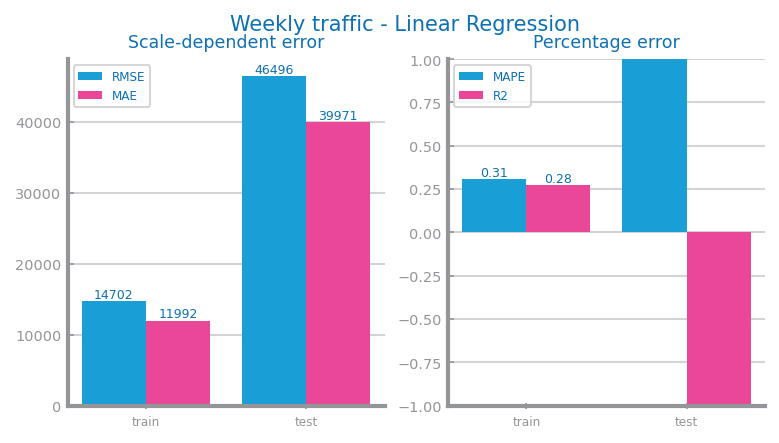

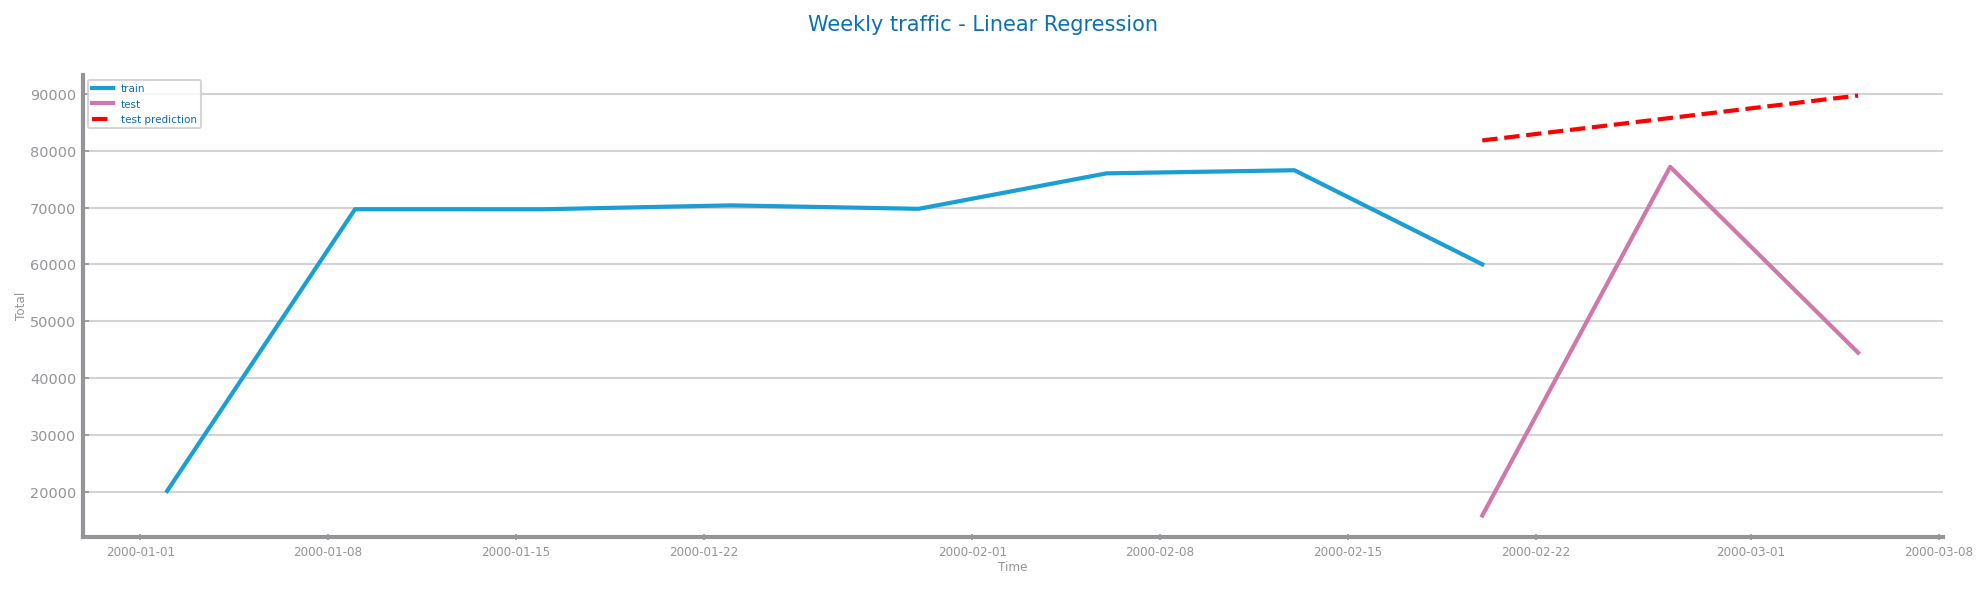

In [17]:
n_trn = len(series_W_train)
n_tst = len(series_W_test)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = series_W_train.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = series_W_test.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn_W: Series = Series(model.predict(trnX), index=series_W_train.index)
prd_tst_W: Series = Series(model.predict(tstX), index=series_W_test.index)

store_metrics("Linear_Regression", "W", series_W_train, series_W_test, prd_trn_W, prd_tst_W)

plot_forecasting_eval(
    series_W_train,
    series_W_test,
    prd_trn_W,
    prd_tst_W,
    title=f"Weekly {file_tag} - Linear Regression"
)
savefig(f"../../charts/preparation/aggregation/{file_tag}_linear_regression_W_eval.png")

plot_forecasting_series(
    series_W_train,
    series_W_test,
    prd_tst_W,
    title=f"Weekly {file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/aggregation/{file_tag}_linear_regression_W_forecast.png")


# Best Model Comparison

In [18]:
# Convert metrics to DataFrame for easy comparison
metrics_df = DataFrame.from_dict(metrics_results, orient='index')
metrics_df = metrics_df.reset_index(drop=True)

# Display all metrics
print("="*80)
print("ALL MODEL METRICS (Test Set)")
print("="*80)
display_df = metrics_df[['model', 'aggregation', 'test_rmse', 'test_mae', 'test_mape', 'test_r2']].copy()
display_df = display_df.sort_values(['model', 'aggregation'])
print(display_df.to_string(index=False))
print()

# Find best models by different criteria
print("="*80)
print("BEST MODELS BY CRITERIA (Test Set)")
print("="*80)

# Best by MAPE (scale-independent, good for comparing across aggregations)
best_mape = metrics_df.loc[metrics_df['test_mape'].idxmin()]
print(f"Best MAPE: {best_mape['model']} ({best_mape['aggregation']}) = {best_mape['test_mape']:.4f}")

# Best by R2 (scale-independent)
best_r2 = metrics_df.loc[metrics_df['test_r2'].idxmax()]
print(f"Best R²: {best_r2['model']} ({best_r2['aggregation']}) = {best_r2['test_r2']:.4f}")

# Best by MAE for each aggregation level
print(f"\nBest MAE by Aggregation Level:")
for agg in ['H', '3H', '6H', 'D', 'W']:
    agg_df = metrics_df[metrics_df['aggregation'] == agg]
    best_mae_agg = agg_df.loc[agg_df['test_mae'].idxmin()]
    print(f"  {agg}: {best_mae_agg['model']} = {best_mae_agg['test_mae']:.2f}")

print()
print("="*80)
print("RECOMMENDATION")
print("="*80)
print(f"Overall Best Model: {best_mape['model']} with {best_mape['aggregation']} aggregation")
print(f"  - Test MAPE: {best_mape['test_mape']:.4f}")
print(f"  - Test R²: {best_mape['test_r2']:.4f}")
print(f"  - Test RMSE: {best_mape['test_rmse']:.2f}")
print(f"  - Test MAE: {best_mape['test_mae']:.2f}")

# Store best model info for later use
best_model_name = best_mape['model']
best_aggregation = best_mape['aggregation']


ALL MODEL METRICS (Test Set)
              model aggregation    test_rmse     test_mae  test_mape   test_r2
  Linear_Regression          3H   595.427346   507.244454   0.517393  0.001047
  Linear_Regression          6H   817.847923   703.712983   0.323757  0.003074
  Linear_Regression           D  1609.220598   788.157518   0.119092  0.026172
  Linear_Regression           H   221.558579   185.486478   0.624872  0.000411
  Linear_Regression           W 46496.166909 39971.166667   1.772072 -2.434988
Persistence_Realist          3H   728.452051   572.430000   0.416372 -0.495166
Persistence_Realist          6H  1971.621957  1793.420000   0.609538 -4.793820
Persistence_Realist           D  4911.461094  4781.000000   0.441124 -8.071364
Persistence_Realist           H   433.127882   372.144295   0.736508 -2.820117
Persistence_Realist           W 28826.828736 25650.333333   1.125259 -0.320336

BEST MODELS BY CRITERIA (Test Set)
Best MAPE: Linear_Regression (D) = 0.1191
Best R²: Linear_Regressi

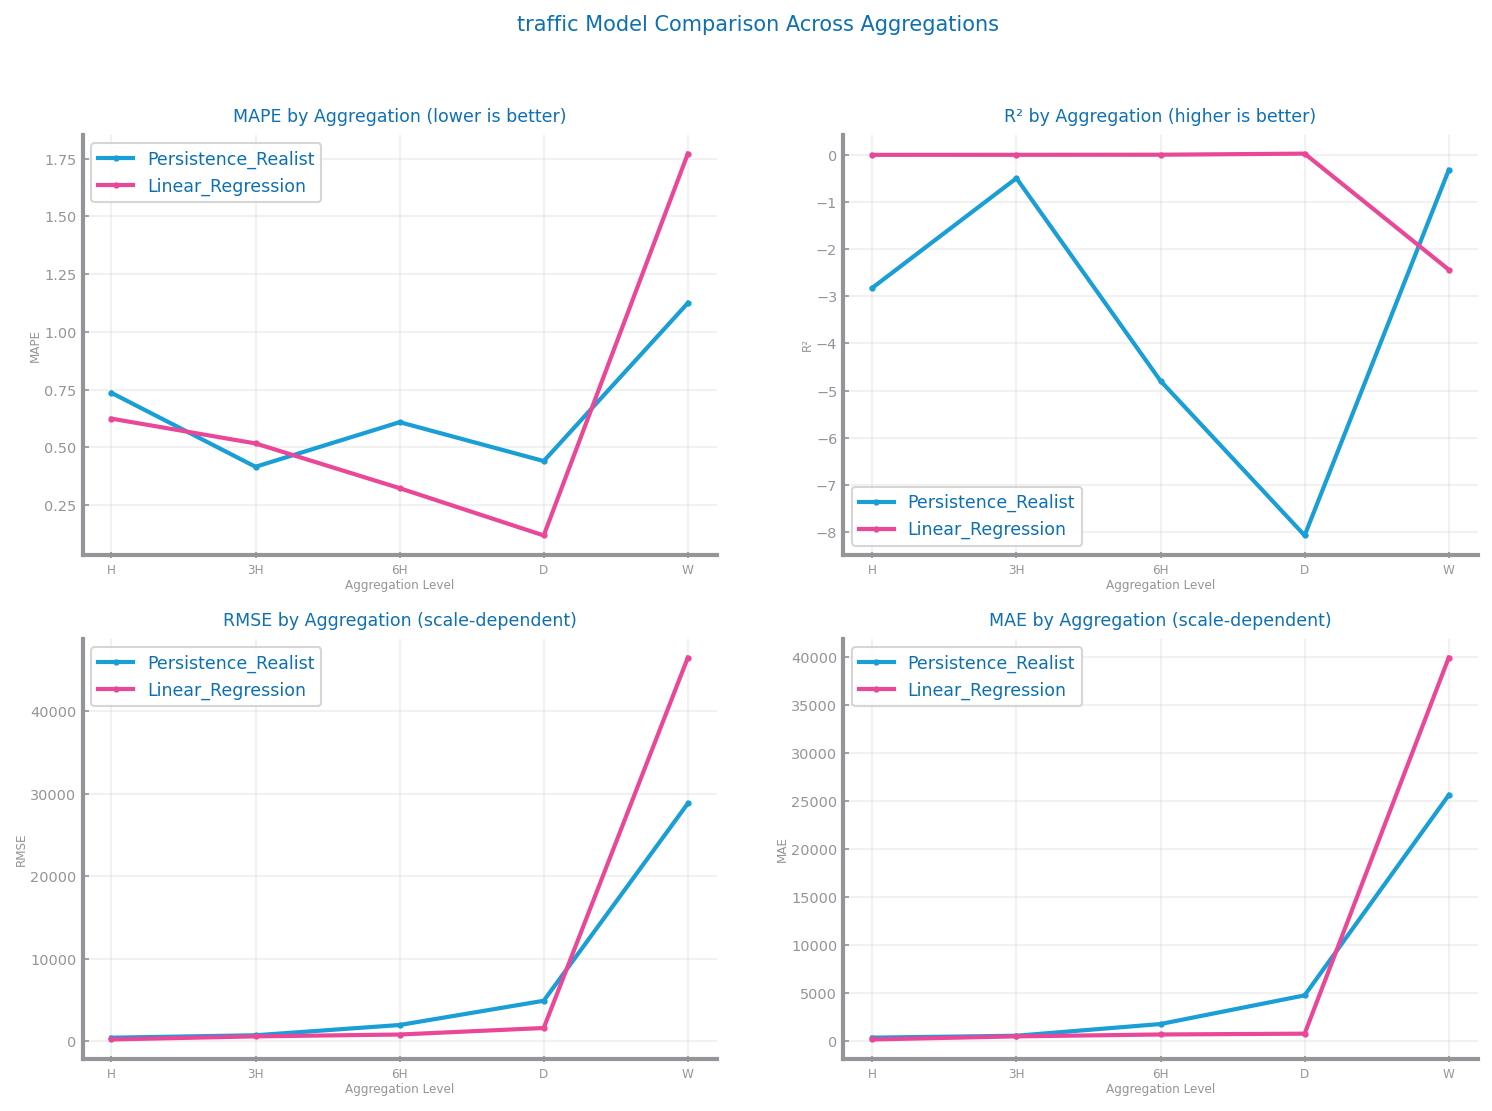

In [19]:
# Visualize model comparison
fig, axs = subplots(2, 2, figsize=(3 * HEIGHT, 2 * HEIGHT))
fig.suptitle(f"{file_tag} Model Comparison Across Aggregations")

# Prepare data for plotting
models = metrics_df['model'].unique()
aggregations = ['H', '3H', '6H', 'D', 'W']

# Plot 1: MAPE comparison (lower is better)
for model in models:
    model_data = metrics_df[metrics_df['model'] == model].sort_values('aggregation', 
                                                                       key=lambda x: x.map({a: i for i, a in enumerate(aggregations)}))
    axs[0, 0].plot(model_data['aggregation'], model_data['test_mape'], marker='o', label=model)
axs[0, 0].set_title('MAPE by Aggregation (lower is better)')
axs[0, 0].set_xlabel('Aggregation Level')
axs[0, 0].set_ylabel('MAPE')
axs[0, 0].legend(fontsize='small')
axs[0, 0].grid(True, alpha=0.3)

# Plot 2: R² comparison (higher is better)
for model in models:
    model_data = metrics_df[metrics_df['model'] == model].sort_values('aggregation', 
                                                                       key=lambda x: x.map({a: i for i, a in enumerate(aggregations)}))
    axs[0, 1].plot(model_data['aggregation'], model_data['test_r2'], marker='o', label=model)
axs[0, 1].set_title('R² by Aggregation (higher is better)')
axs[0, 1].set_xlabel('Aggregation Level')
axs[0, 1].set_ylabel('R²')
axs[0, 1].legend(fontsize='small')
axs[0, 1].grid(True, alpha=0.3)

# Plot 3: RMSE comparison
for model in models:
    model_data = metrics_df[metrics_df['model'] == model].sort_values('aggregation', 
                                                                       key=lambda x: x.map({a: i for i, a in enumerate(aggregations)}))
    axs[1, 0].plot(model_data['aggregation'], model_data['test_rmse'], marker='o', label=model)
axs[1, 0].set_title('RMSE by Aggregation (scale-dependent)')
axs[1, 0].set_xlabel('Aggregation Level')
axs[1, 0].set_ylabel('RMSE')
axs[1, 0].legend(fontsize='small')
axs[1, 0].grid(True, alpha=0.3)

# Plot 4: MAE comparison
for model in models:
    model_data = metrics_df[metrics_df['model'] == model].sort_values('aggregation', 
                                                                       key=lambda x: x.map({a: i for i, a in enumerate(aggregations)}))
    axs[1, 1].plot(model_data['aggregation'], model_data['test_mae'], marker='o', label=model)
axs[1, 1].set_title('MAE by Aggregation (scale-dependent)')
axs[1, 1].set_xlabel('Aggregation Level')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].legend(fontsize='small')
axs[1, 1].grid(True, alpha=0.3)

savefig(f"../../charts/preparation/aggregation/{file_tag}_model_comparison.png")
show()


In [20]:
output_train_path = "../../data/prepared/aggregation/traffic_train_aggregation.csv"
output_test_path  = "../../data/prepared/aggregation/traffic_test_aggregation.csv"

# Automatically select the best aggregation based on MAPE
aggregation_map = {
    'H': (series_H_train, series_H_test),
    '3H': (series_3H_train, series_3H_test),
    '6H': (series_6H_train, series_6H_test),
    'D': (series_D_train, series_D_test),
    'W': (series_W_train, series_W_test)
}

best_train, best_test = aggregation_map[best_aggregation]

# Ensure they are DataFrames so the index is preserved cleanly
best_train.to_frame(name="Total").to_csv(output_train_path)
best_test.to_frame(name="Total").to_csv(output_test_path)

print(f"Saved {best_aggregation} aggregated train/test sets (best model: {best_model_name}).")
print(f"Train shape: {best_train.shape}")
print(f"Test shape: {best_test.shape}")


Saved D aggregated train/test sets (best model: Linear_Regression).
Train shape: (50,)
Test shape: (13,)


In [21]:
# Save metrics to CSV for reference
metrics_output_path = "../../data/prepared/aggregation/traffic_aggregation_metrics.csv"
metrics_df.to_csv(metrics_output_path, index=False)
print(f"Saved metrics to {metrics_output_path}")

# Display summary
metrics_df


Saved metrics to ../../data/prepared/aggregation/traffic_aggregation_metrics.csv


,model,aggregation,train_rmse,test_rmse,train_mae,test_mae,train_mape,test_mape,train_r2,test_r2
0,Persistence_Realist,H,397.635998,433.127882,341.149454,372.144295,0.725878,0.736508,-2.788856,-2.820117
1,Persistence_Realist,3H,647.565900,728.452051,498.284635,572.430000,0.377349,0.416372,-0.366753,-0.495166
2,Persistence_Realist,6H,1793.846376,1971.621957,1619.412060,1793.420000,0.585621,0.609538,-4.404673,-4.793820
3,Persistence_Realist,D,4379.986091,4911.461094,4308.160000,4781.000000,0.415615,0.441124,-29.742283,-8.071364
4,Persistence_Realist,W,17732.182029,28826.828736,14008.500000,25650.333333,0.372284,1.125259,-0.054536,-0.320336
5,Linear_Regression,H,203.732668,221.558579,167.199665,185.486478,0.569688,0.624872,0.005378,0.000411
6,Linear_Regression,3H,552.086477,595.427346,467.001338,507.244454,0.466563,0.517393,0.006572,0.001047
7,Linear_Regression,6H,767.603493,817.847923,669.136606,703.712983,0.319243,0.323757,0.010370,0.003074
8,Linear_Regression,D,763.135233,1609.220598,375.687919,788.157518,0.042294,0.119092,0.066759,0.026172
9,Linear_Regression,W,14701.886305,46496.166909,11992.250000,39971.166667,0.308936,1.772072,0.275091,-2.434988
